### File for creating "preceding  metrics" plots for predictions. 

But this time they're both models. 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

In [2]:
shift = 14
#this is used to change the start date from October 19 to November 2nd... and just reduce the overall time observed.
#0 if no change. 

idx = 135

Open and pre-process ellipse metrics. 

In [3]:
##open ellipse metric files
infile = open("../data/ellipse/wind10_redo.p", 'rb') 
wind10 = pickle.load(infile)
infile.close()

infile = open("../data/ellipse/size10_redo.p", 'rb') 
size10 = pickle.load(infile)
infile.close()

infile = open("../data/ellipse/ratio10_redo.p", 'rb') 
rat10 = pickle.load(infile)
infile.close()

infile = open("../data/ellipse/ephi10_redo.p", 'rb') 
ephi10 = pickle.load(infile)
infile.close()

infile = open("../data/ellipse/cenlat10_redo.p", 'rb')
cenlat10 = pickle.load(infile)
infile.close()

infile = open("../data/ellipse/cenlon10_redo.p", 'rb')
cenlon10 = pickle.load(infile)
infile.close()

infile = open("../data/gph/NA_gph_weightedANOM_100.p", 'rb') 
gph = pickle.load(infile)
infile.close()

infile = open("../data/pv/CAP_pvu_weightedANOM.p", 'rb') 
pv = pickle.load(infile)
infile.close()


#load LSTM data
infile = open("../../REAL/eof_data/vertanom_u.p","rb",)
u_input = pickle.load(infile)  ##vertical U cross section
U_14 = u_input[52:62, 19:168, :, :].reshape((10, 149, 37, 36))
infile.close()

infile = open("../../REAL/eof_data/vertanom_ehf.p","rb",)
ehf_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
EHF_14 = ehf_input[52:62, 19:168, :, :].reshape((10, 149, 37, 180))
infile.close()

infile = open("../../REAL/eof_data/vertanom_gph.p","rb",)
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
GPH_14= gph_input[52:62, 19:168, :, :].reshape((10, 149, 37, 180))
infile.close()

print("U Wind shape: ",U_14.shape)
print("EHF shape: ",EHF_14.shape)
print("GPH shape: ",GPH_14.shape)

U Wind shape:  (10, 149, 37, 36)
EHF shape:  (10, 149, 37, 180)
GPH shape:  (10, 149, 37, 180)


In [4]:
#remove leap year
##CHANGE IF NOT EXTENDED DATAQ BACK TO 120
wind10 = np.delete(wind10[:62],[151],1)
rat10 = np.delete(rat10[:62],[151],1)
cenlat10 = np.delete(cenlat10[:62],[151],1)
cenlon10 = np.delete(cenlon10[:62],[151],1)
size10 = np.delete(size10[:62],[151],1)
ephi10 = np.delete(ephi10[:62],[151],1)

In [5]:
wind10 = wind10[:,19+shift:168]
rat10 = rat10[:,19+shift:168]
cenlat10 = cenlat10[:,19+shift:168]
cenlon10 = cenlon10[:,19+shift:168]
size10 = size10[:,19+shift:168]
ephi10 = ephi10[:,19+shift:168]
gph = gph[:62,19+shift:168]
pv = pv[:62,19+shift:168]

U_14 = U_14[:,shift:]
EHF_14 = EHF_14[:,shift:]
GPH_14 = GPH_14[:,shift:]

In [6]:
#remove NaNs from ellipse data. 
##CHANGE IF NOT EXTENDED DATA
test_comp = []
indices = np.isnan(wind10)
for i in range(0,62):
    for j in range(0,idx):
        if indices[i,j] != False:
            print(i)
            print(j)
            print("True")
            wind10[i,j] = 0
            rat10[i,j] = 0
            cenlat10[i,j] = 0
            cenlon10[i,j] = 0
            size10[i,j] = 0
            ephi10[i,j] = 0
            if i >= 57:
                test_comp.append((i,j))
            else:
                continue

6
124
True
13
112
True
17
71
True
18
95
True
19
127
True
19
128
True
19
129
True
24
127
True
24
128
True
24
129
True
24
130
True
24
131
True
24
132
True
24
133
True
24
134
True
27
109
True
27
110
True
27
111
True
27
112
True
27
113
True
27
114
True
27
115
True
28
133
True
28
134
True
29
118
True
29
127
True
29
128
True
29
129
True
29
130
True
29
131
True
29
132
True
29
133
True
29
134
True
36
132
True
39
121
True
39
122
True
39
123
True
39
124
True
39
125
True
39
126
True
39
127
True
39
128
True
39
129
True
39
130
True
39
131
True
39
132
True
39
133
True
39
134
True
41
107
True
41
108
True
41
109
True
41
110
True
41
111
True
41
112
True
41
113
True
48
134
True
49
89
True
49
94
True
49
95
True
49
96
True
49
97
True
49
98
True
49
99
True
49
100
True
49
101
True
49
102
True
49
103
True
49
104
True
49
105
True
49
106
True
49
107
True
49
108
True
49
109
True
49
110
True
49
111
True
49
112
True
49
113
True
49
114
True
49
115
True
49
116
True
49
117
True
49
118
True
56
134
True
58
114
True


In [7]:
print(wind10.shape)
print(U_14.shape)

(62, 135)
(10, 135, 37, 36)


In [8]:
##turn ellipse metrtics into daily values. 
def daily_anomaly(target):
    dailymean = np.nanmean(target,axis=1)
    anom = np.zeros_like(target)
    for t in np.arange(target.shape[1]):
         anom[:,t] = target[:,t] - dailymean
    print(anom.shape)
    return anom; 

In [9]:
input2 = np.empty((62,idx,4))

In [10]:
##seus:
input2[:,:,3] = daily_anomaly(cenlat10[:,:])
input2[:,:,2] = daily_anomaly(gph[:,:])
input2[:,:,1] = daily_anomaly(wind10[:,:])
input2[:,:,0] = daily_anomaly(size10[:,:])

(62, 135)
(62, 135)
(62, 135)
(62, 135)


In [11]:
##reduce input to just the testing data
nolag_Xtest = input2[52:,:,:]
nolag_Xtest.shape

(10, 135, 4)

Now that the assembly is done ... We can plot. lol.

### Open Index files.

In [12]:
##open indice files
infile = open("sharedPOS_seus14.p", 'rb') 
posXtest = pickle.load(infile)
infile.close()

infile = open("sharedFPOS_seus14.p", 'rb') 
FposXtest = pickle.load(infile)
infile.close()

infile = open("sharedNEG_seus14.p", 'rb') 
negXtest = pickle.load(infile)
infile.close()

infile = open("sharedFNEG_seus14.p", 'rb') 
FnegXtest = pickle.load(infile)
infile.close()

In [13]:
####now I wanna make these plots SO ... I am adding an index column on to X_test ... full version. 
ranges = np.array([x for x in range(0,idx*10,1)])
ranges = ranges.reshape(10,idx) 
ranges.shape

(10, 135)

In [14]:
##set lat and lon arrays
##separate set of longitudes for PV and others
lat = np.arange(90, 18, -2)
print("Len latitudes: ", len(lat))
lon = np.arange(0, 360, 2)
print("Len longitudes: ", len(lon))


lev = np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70., 100., 125., 150., 175., 200., 225., 250., 300., 350., 400., 
                450., 500., 550., 600., 650., 700., 750., 775., 800., 825., 850., 875., 900., 925., 950., 975., 1000.])
print("Len levels: ", len(lev))

Len latitudes:  36
Len longitudes:  180
Len levels:  37


## Cross Section plots. 

In [15]:
##index of desired date
index = 13

## 13 for SEUS (T-0)
## 13 for Canada (T-0)
## 10 for Europe (T-3)

In [16]:
##Correct Positive Events
U_cpos = np.empty((len(posXtest), 37, 36))
EHF_cpos = np.empty((len(posXtest), 37, 180))
GPH_cpos = np.empty((len(posXtest), 37, 180))

for i in range(0,10):
    for j in range(0,121):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(posXtest)):
            pos_index = posXtest[k]
            if pos_index == date_index:
                U_cpos[k,:,:] = U_14[i,j+index,:,:]
                EHF_cpos[k,:,:] = EHF_14[i,j+index,:,:]
                GPH_cpos[k,:,:] = GPH_14[i,j+index,:,:]

print("Positive Events")
print(U_cpos.shape)

##False Positive Events
U_Fpos = np.empty((len(FposXtest), 37, 36))
EHF_Fpos = np.empty((len(FposXtest), 37, 180))
GPH_Fpos = np.empty((len(FposXtest), 37, 180))

for i in range(0,10):
    for j in range(0,121):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(FposXtest)):
            pos_index = FposXtest[k]
            if pos_index == date_index:
                U_Fpos[k,:,:] = U_14[i,j+index,:,:]
                EHF_Fpos[k,:,:] = EHF_14[i,j+index,:,:]
                GPH_Fpos[k,:,:] = GPH_14[i,j+index,:,:]

print("False Positive Events")
print(U_Fpos.shape)

##Correct Negative Events
U_cneg = np.empty((len(negXtest), 37, 36))
EHF_cneg = np.empty((len(negXtest), 37, 180))
GPH_cneg = np.empty((len(negXtest), 37, 180))

for i in range(0,10):
    for j in range(0,121):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(negXtest)):
            neg_index = negXtest[k]
            if neg_index == date_index:
                U_cneg[k,:,:] = U_14[i,j+index,:,:]
                EHF_cneg[k,:,:] = EHF_14[i,j+index,:,:]
                GPH_cneg[k,:,:] = GPH_14[i,j+index,:,:]
                
print("Negative Events")
print(U_cneg.shape)
                
##False Negative Events
U_Fneg = np.empty((len(FnegXtest), 37, 36))
EHF_Fneg = np.empty((len(FnegXtest), 37, 180))
GPH_Fneg = np.empty((len(FnegXtest), 37, 180))

for i in range(0,10):
    for j in range(0,121):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(FnegXtest)):
            neg_index = FnegXtest[k]
            if neg_index == date_index:
                U_Fneg[k,:,:] = U_14[i,j+index,:,:]
                EHF_Fneg[k,:,:] = EHF_14[i,j+index,:,:]
                GPH_Fneg[k,:,:] = GPH_14[i,j+index,:,:]
                
print("False Negative Events")
print(U_Fneg.shape)

Positive Events
(73, 37, 36)
False Positive Events
(17, 37, 36)
Negative Events
(101, 37, 36)
False Negative Events
(65, 37, 36)


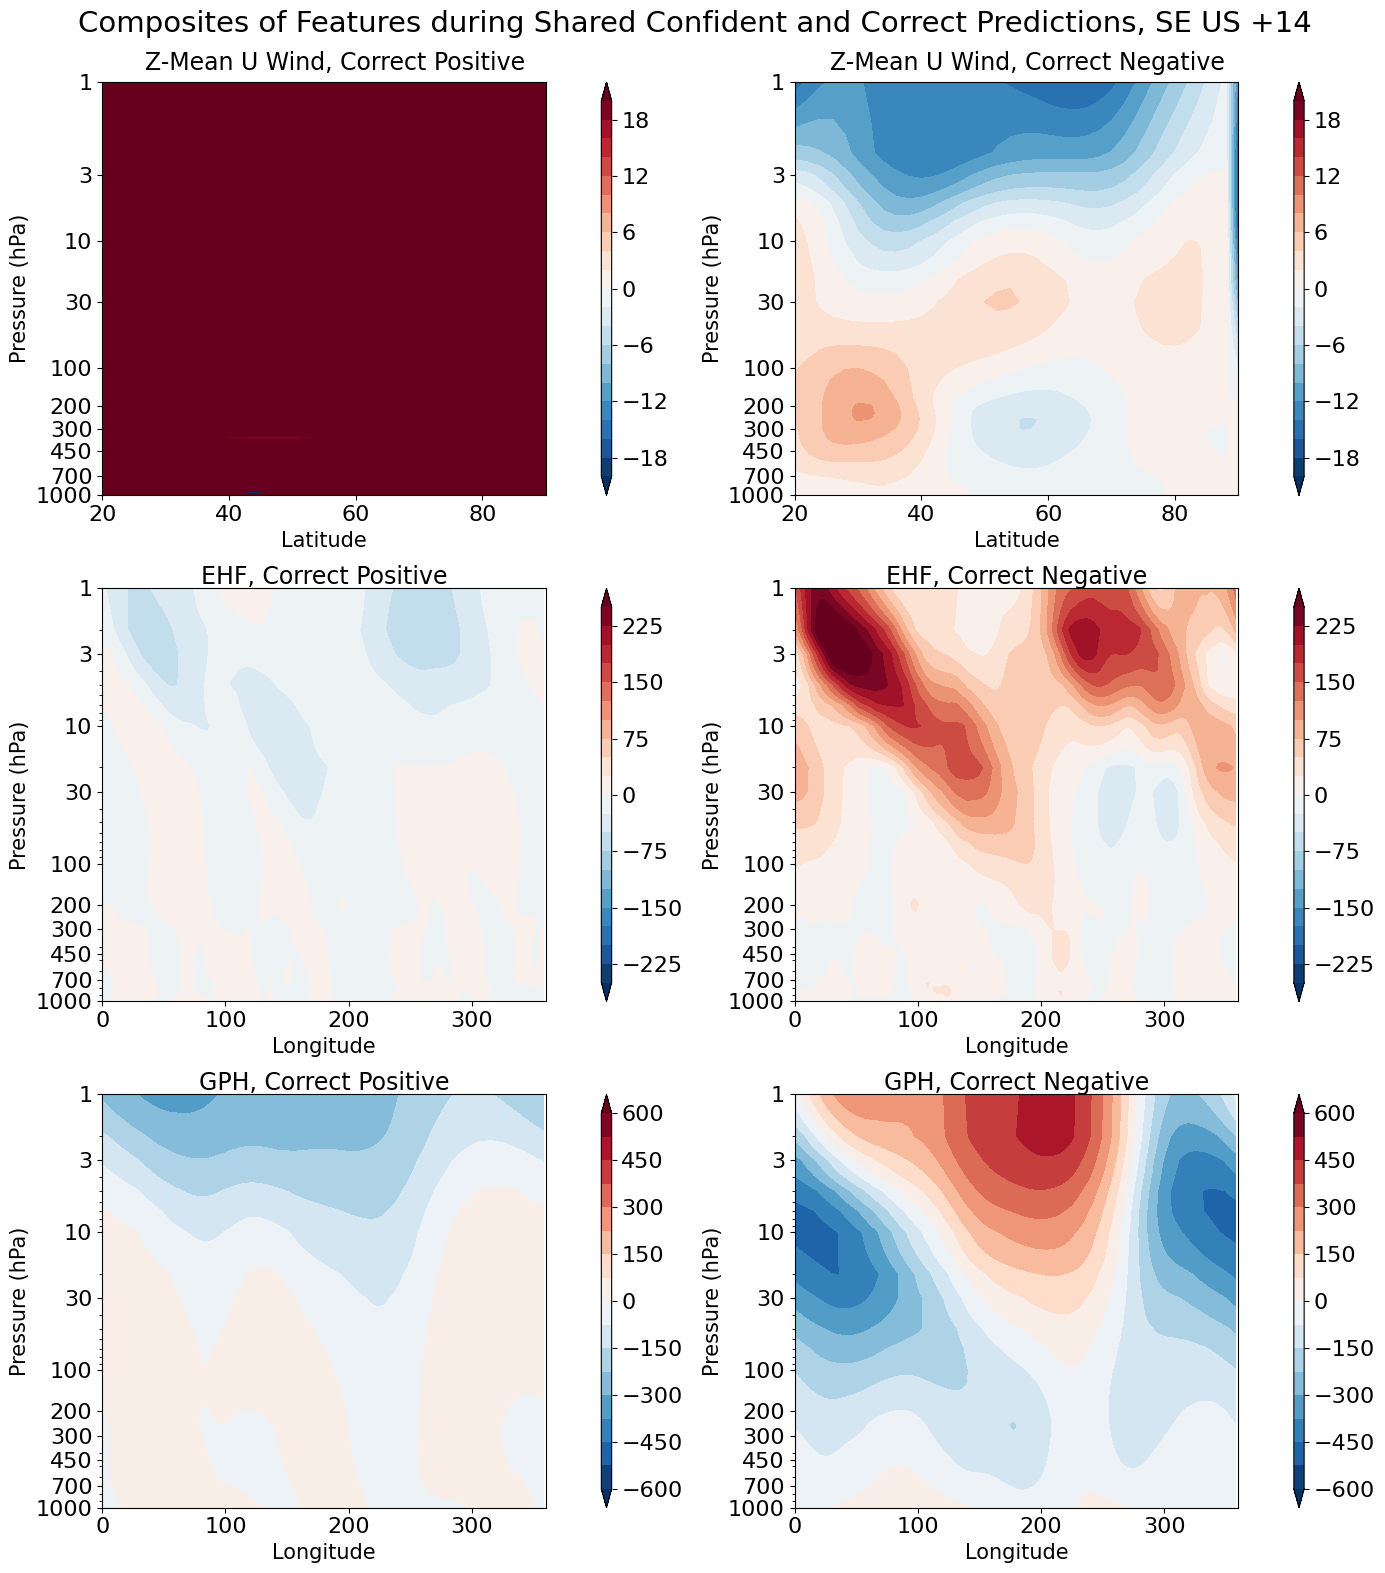

In [17]:
fs = 18
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
plt.suptitle("Composites of Features during Shared Confident and Correct Predictions, SE US +14",fontsize=21)   
titles = ["Correct Positive", "Correct Negative"]
data = [U_cpos,U_cneg,EHF_cpos,EHF_cneg,GPH_cpos,GPH_cneg]

axes = axes.flatten()
#remove the last (empty) axis

for i in range(0, 6):
    color = "RdBu_r"
    # colorbar options:
    if i == 0 or i ==1:
        colorbarMin = -20
        colorbarMax = 20
        colorspace = 2

        clevel = np.arange(colorbarMin, colorbarMax + colorspace, colorspace)
        axes[i].set_title("Z-Mean U Wind, "+str(titles[i]), fontsize=fs-1, y=1.01,x=0.525)

        h = axes[i].contourf(
            lat,
            lev,
            np.nanmean(data[i], axis = 0),
            clevel,
            cmap=color,
            extend="both",
        )
        cbar = plt.colorbar(
            h, orientation="vertical", shrink=1, fraction=0.1, pad=0.1, aspect=40
        )
        cbar.ax.tick_params(labelsize=fs-2)
        # colorLabel='Z (m)'
        # cbar.set_label(label=colorLabel,fontsize=10)

        axes[i].tick_params(labelsize=fs-2)
        axes[i].invert_yaxis()
        axes[i].set_yscale('symlog')
        axes[i].set_ylabel('Pressure (hPa)', fontsize=fs-3)
        axes[i].set_yticks([1, 3, 10, 30, 100, 200, 300, 450, 700, 1000]) 
        axes[i].get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

        axes[i].set_xlim(20, 90)
        axes[i].set_xlabel('Latitude', fontsize=fs-3)
                          
    if i == 2 or i == 3:
        colorbarMin = -250
        colorbarMax = 250
        colorspace = 25

        clevel = np.arange(colorbarMin, colorbarMax + colorspace, colorspace)
        axes[i].set_title("EHF, "+str(titles[i-2]), fontsize=fs-1, y=0.99) 
                          
        h = axes[i].contourf(
            lon,
            lev,
            np.nanmean(data[i], axis = 0),
            clevel,
            cmap=color,
            extend="both",
        )
        cbar = plt.colorbar(
            h, orientation="vertical", shrink=1, fraction=0.1, pad=0.1, aspect=40
        )
        cbar.ax.tick_params(labelsize=fs-2)
        axes[i].tick_params(labelsize=fs-2)
        axes[i].set_yscale('log')
        axes[i].invert_yaxis()
        axes[i].set_ylabel('Pressure (hPa)', fontsize=fs-3)
        axes[i].set_yticks([1, 3, 10, 30, 100, 200, 300, 450, 700, 1000]) 
        axes[i].get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

        axes[i].set_xlim(0, 360)
        axes[i].set_xlabel('Longitude', fontsize=fs-3)
                          
    if i == 4 or i == 5:
        colorbarMin = -600
        colorbarMax = 600
        colorspace = 75

        clevel = np.arange(colorbarMin, colorbarMax + colorspace, colorspace)
        axes[i].set_title("GPH, "+str(titles[i-4]), fontsize=fs-1, y=0.99) 
                          
        h = axes[i].contourf(
            lon,
            lev,
            np.nanmean(data[i], axis = 0),
            clevel,
            cmap=color,
            extend="both",
        )
        cbar = plt.colorbar(
            h, orientation="vertical", shrink=1, fraction=0.1, pad=0.1, aspect=40
        )
        cbar.ax.tick_params(labelsize=fs-2)
        axes[i].tick_params(labelsize=fs-2)
        axes[i].set_yscale('log')
        axes[i].invert_yaxis()
        axes[i].set_ylabel('Pressure (hPa)', fontsize=fs-3)
        axes[i].set_yticks([1, 3, 10, 30, 100, 200, 300, 450, 700, 1000]) 
        axes[i].get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

        axes[i].set_xlim(0, 360)
        axes[i].set_xlabel('Longitude', fontsize=fs-3)


plt.tight_layout()
plt.subplots_adjust(top=0.935)
plt.savefig("Seus14_SharedComps_Correct.png")
plt.show()

## Boxplot.

In [18]:
##Correct Positive Events
pos_corr_events = []
pos_corr_num = []
pos_corr_total_events = []

for i in range(0,10):
    for j in range(0,idx):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(posXtest)):
            pos_index = posXtest[k]
            if pos_index == date_index:
                pos_corr_total_events.append(0)
                pos_corr_num.append(0)
                pos_corr_events.extend(nolag_Xtest[i,j,:])

##reshape
pos = np.array(pos_corr_events).reshape((len(pos_corr_num),1,4))
print("Positive Events")
print(pos.shape)
print(len(pos_corr_total_events))

##FALSE Positive Events
Fpos_corr_events = []
Fpos_corr_num = []
Fpos_corr_total_events = []

for i in range(0,10):
    for j in range(0,idx):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(FposXtest)):
            pos_index = FposXtest[k]
            if pos_index == date_index:
                Fpos_corr_total_events.append(0)
                Fpos_corr_num.append(0)
                Fpos_corr_events.extend(nolag_Xtest[i,j,:])
##reshape
Fpos = np.array(Fpos_corr_events).reshape((len(Fpos_corr_num),1,4))
print("False Positive Events")
print(Fpos.shape)
print(len(Fpos_corr_total_events))

##Correct Negative Events
neg_corr_events = []
neg_corr_num = []
neg_corr_total_events = []

for i in range(0,10):
    for j in range(0,idx):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(negXtest)):
            neg_index = negXtest[k]
            if neg_index == date_index:
                neg_corr_total_events.append(0)
                neg_corr_num.append(0)
                neg_corr_events.extend(nolag_Xtest[i,j,:])
##reshape
neg = np.array(neg_corr_events).reshape((len(neg_corr_num),1,4))
print("Negative Events")
print(neg.shape)
print(len(neg_corr_total_events))

##FALSE Negative Events
Fneg_corr_events = []
Fneg_corr_num = []
Fneg_corr_total_events = []
test = []

for i in range(0,10):
    for j in range(0,idx):
        #index for the date being observed
        date_index = ranges[i,j]
        ##loop through indexes of positive and correct events
        for k in range(len(FnegXtest)):
            neg_index = FnegXtest[k]
            if neg_index == date_index:
                Fneg_corr_total_events.append(0)
                Fneg_corr_num.append(0)
                Fneg_corr_events.extend(nolag_Xtest[i,j,:])
                test.append((i,j))
                

##reshape
Fneg = np.array(Fneg_corr_events).reshape((len(Fneg_corr_num),1,4))
print("False Negative Events")
print(Fneg.shape)
print(len(Fneg_corr_total_events))

Positive Events
(73, 1, 4)
73
False Positive Events
(17, 1, 4)
17
Negative Events
(101, 1, 4)
101
False Negative Events
(65, 1, 4)
65


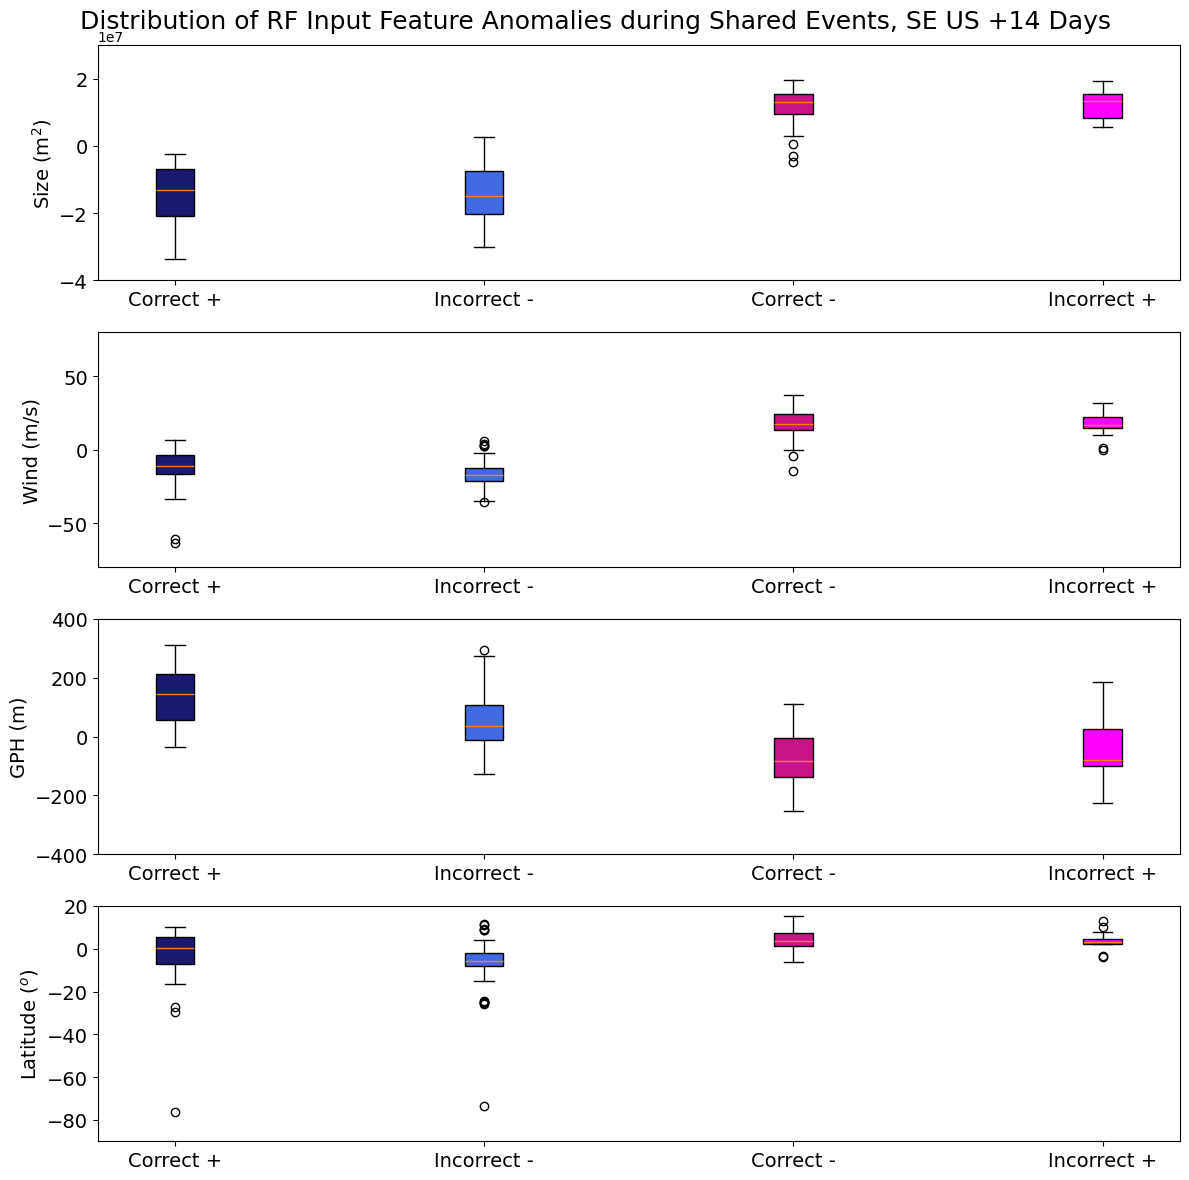

In [19]:
import matplotlib.ticker as mticker
myLocator = mticker.MultipleLocator(2)

##SEUS
metrics = ["Size (m$^2$)", "Wind (m/s)", "GPH (m)", "Latitude ($^o$)"]
y1 = [-40000000,-80,-400,-90]
y2 = [30000000,80,400,20]

##CAN
#metrics = ["GPH (m)","Wind (m/s)","PV (m$^2$K/s kg)", "Latitude ($^o$)"]
#y1 = [-400,-80,-2,-90]
#y2 = [400,80,2,20]

##EUR
#metrics = ["GPH (m)", "Longitude ($^o$)", "Latitude ($^o$)","Wind (m/s)"]
#y1 = [-400,-200,-90,-80]
#y2 = [400,100,20,80]

ticks = ['Correct +', 'Incorrect -', 'Correct -', 'Incorrect +'] #set tick numbers for dataset
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
c = ["midnightblue","royalblue","mediumvioletred","magenta"]
fs = 14

fig, axes = plt.subplots(4, 1, figsize=(12, 12))
plt.suptitle("Distribution of RF Input Feature Anomalies during Shared Events, SE US +14 Days", fontsize = 18, x=0.50)
axes = axes.flatten()
for i in range(0,4):
    C_pos = pos[:,0,i]
    F_neg = Fneg[:,0,i]
    C_neg = neg[:,0,i]
    F_pos = Fpos[:,0,i]
        
    a1 =axes[i].boxplot([C_pos,F_neg,C_neg,F_pos], positions= [2,4,6,8], widths=w, patch_artist=True)
    for bplot in (a1,):
        for patch, color in zip(bplot['boxes'], c):
            patch.set_facecolor(color)
    axes[i].set_xticks(ind, ticks, fontsize = 14)
    axes[i].set_ylim((y1[i],y2[i]))
    axes[i].set_ylabel(str(metrics[i]), fontsize = 14)
    axes[i].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.95)   
plt.savefig("Seus_SharedBOXPLOT.png",bbox_inches = 'tight')
plt.show()